In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import sympy as sym

# Image loading packages
from PIL import Image
from io import BytesIO
import requests

image_array.shape:  (250, 250)


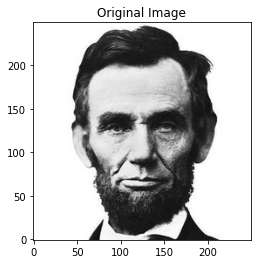

In [195]:
# Loads an online image as a numpy array
# URL of the image
image_url = 'https://raw.githubusercontent.com/MurpheyLab/ME455_public/main/figs/lincoln.jpg'

# Fetch the image data from the URL
response = requests.get(image_url)

# Create a BytesIO object from the response data
image_data = BytesIO(response.content)

# Open the image using PIL
image = Image.open(image_data)

# Convert the image to a NumPy array
image_array = np.array(image)
image_array = np.flip(image_array, axis=0)

print('image_array.shape: ', image_array.shape)
plt.title("Original Image")
plt.imshow(image_array, origin='lower', cmap='gray') # note that for "imshow" the origin of the coordinate is at top left instead of bottom left
plt.show()
plt.close()

In [83]:
xgrids = np.linspace(0.0, 1.0, image_array.shape[0])  # the x coordinates of image pixels in the new space
dx = xgrids[1] - xgrids[0]
ygrids = np.linspace(0.0, 1.0, image_array.shape[1])  # the y coordinates of image pixels in the new space
dy = ygrids[1] - ygrids[0]

# we now invert dark and light pixel density and normalize the density values so it is a valid probability distribution
density_array = 255.0 - image_array  # we want higher density at darker regions
density_array /= np.sum(density_array) * dx * dy  # so the integral is 1

def image_density(s):
    """ Continuous density function based on the image
    Inputs:
        s - a numpy array containing the (x,y) coordinate within the 1m-by-1m space
    Return:
        val - the density value at s
    """
    s_x, s_y = s

    # Find the pixel closest to s in the 1-by-1 space
    # Note that in image the first pixel coordinate correspond to the y-axis in the 1-by-1 space
    pixel_idx_y = np.argmin(np.abs(xgrids - s_x))
    pixel_idx_x = np.argmin(np.abs(ygrids - s_y))

    # the density at s is the same as the closest pixel density
    val = density_array[pixel_idx_x, pixel_idx_y]

    return val

#### Converting image to a continuous density function

We assume this image represents a continuous density function p(x) over a 1 meter-by-1 meter space.
In other words, we will convert the coordinate of each pixel of this 250-by-250 image to a 1m-by-1m space.

For example, the bottom right pixel has the coordinate (249,249) in the image coordinate, we will transform it to be (1.0, 1.0) in the new space.

**Note: we want higher density at regions that are darker, so we need to evaluate the density as "255 - pixel_density".**

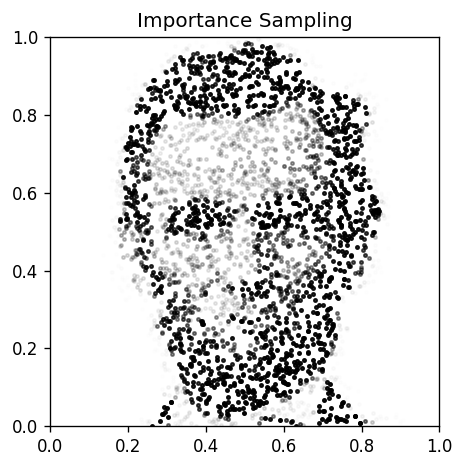

In [84]:
# Problem 1
# We can verify the density function through importance sampling
num_samples = 5000
samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples,2))
sample_weights = np.zeros(num_samples)

for i in range(num_samples):
    sample_weights[i] = image_density(samples[i])

# for visualization purpose, we adjust the weights such that the maximum weight is 1.0
# (matplotlib only accepts values between 0.0 to 1.0 as the opacity value)
# (this is not the same as normalization in importance sampling or rejection sampling)
sample_weights /= np.max(sample_weights)

# now we visualize the weighted samples
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=120, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

for sample, weight in zip(samples, sample_weights):
    ax.plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k', alpha=weight)

plt.title("Importance Sampling")
plt.show()
plt.close()

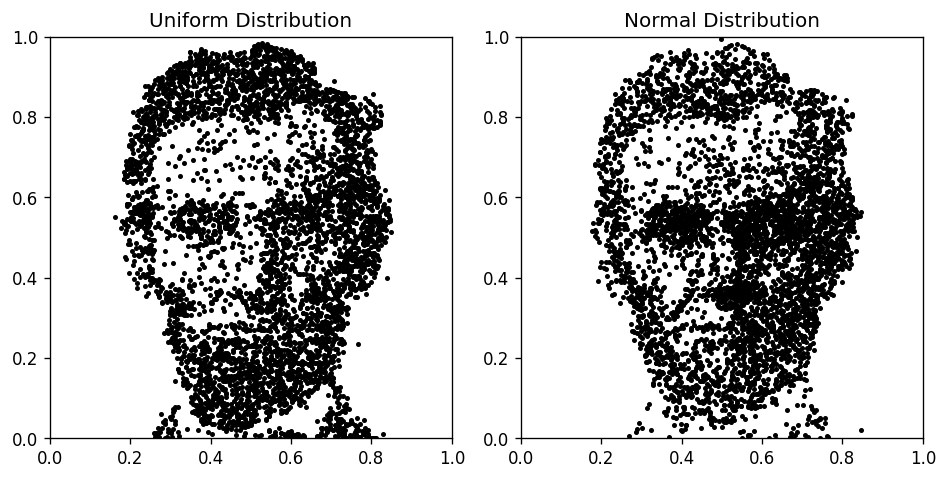

In [85]:
# We can verify the density function through importance sampling
num_samples = 5000

## rejection sampling
def rejection_sample(num_samples, M, sample_type=0):
    accepted_samples = []
    while len(accepted_samples) < num_samples:
        scalar_sample = np.random.uniform(low=0.0, high=1.0)

        if sample_type == 0:
            # uniform sampling
            sample = np.random.uniform(low=0.0, high=1.0, size=2)
        else:
            # normal sampling
            sample = np.random.normal(loc=0.50, scale=0.25, size=2)
        if scalar_sample*M < image_density(sample):
            accepted_samples.append(sample)

    return np.array(accepted_samples)

# now we visualize the accepted samples
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=120, tight_layout=True)

# Plot samples for uniform distribution
axs[0].set_title("Uniform Distribution")
axs[0].set_aspect('equal')
axs[0].set_xlim(0.0, 1.0)
axs[0].set_ylim(0.0, 1.0)

acc_samples = rejection_sample(num_samples, M=5.0, sample_type=0)
for sample in acc_samples:
    axs[0].plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k')

# Plot samples for normal distribution
axs[1].set_title("Normal Distribution")
axs[1].set_aspect('equal')
axs[1].set_xlim(0.0, 1.0)
axs[1].set_ylim(0.0, 1.0)

acc_samples = rejection_sample(num_samples, M=5.0, sample_type=1)
for sample in acc_samples:
    axs[1].plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k')

plt.show()
plt.close()


In [86]:
# Problem 2

# particle filter implemntation for a differential drive robot

ground_truth = np.array([0.0, 0.0, (np.pi/2.0)]) # x, y, theta

num_particles = 100

# initialize the particles
# sample from a gaussian distribution centered at (0.0, 0.0) with variance 0.02
# the particles are in the form of (x, y, theta)
particles = np.random.normal(loc=0.0, scale=np.sqrt(0.02), size=(num_particles, 2)) # x, y
particles = np.concatenate((particles, np.zeros((num_particles, 1))), axis=1) # theta
particles[:, 2] = np.random.uniform(low=-np.pi, high=np.pi, size=num_particles) # theta

weights = np.ones(num_particles) / num_particles

# define the state transition motion model
def state_transition_model(s, u, dt):
    x, y, theta = s
    u_1, u_2 = u

    x += u_1 * np.cos(theta) * dt
    y += u_1 * np.sin(theta) * dt
    theta += u_2 * dt

    s_new = np.array([x, y, theta]) + np.random.normal(loc=0.0, scale=np.sqrt(0.002), size=3)

    return s_new

# define the control signal
u = np.array([1.0, -0.5])
dt = 0.1

# implement a measurement model to calulate the weights
def measurement_model(ground_truth, particle):
    x_gt, y_gt, theta_gt = ground_truth
    x, y, theta = particle

    # compute the weight associated with the particle given the ground truth
    # based on a gaussian distribution centered at the ground truth with variance 0.02
    weight = np.exp(-0.5 * ((x_gt - x)**2 + (y_gt - y)**2) / 0.02) / np.sqrt(2.0 * np.pi * 0.02)

    return weight

# particle filter algorithm
T_time = 2*np.pi

ground_truth_trajectory = []
particles_trajectory = []
weights_trajectory = []

ground_truth_trajectory.append(ground_truth)
particles_trajectory.append(particles)
weights_trajectory.append(weights)

for t in np.arange(0.0, T_time, dt):
    # motion update
    particles = np.array([state_transition_model(particle, u, dt) for particle in particles])
    ground_truth = state_transition_model(ground_truth, u, dt)

    # save the ground truth and particles
    ground_truth_trajectory.append(ground_truth)
    particles_trajectory.append(particles)

    # measurement update
    weights = np.array([measurement_model(ground_truth, particle) for particle in particles])
    weights /= np.sum(weights) # normalize the weights

    weights_trajectory.append(weights)

    # resampling
    indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
    particles = particles[indices]

ground_truth_trajectory = np.array(ground_truth_trajectory)
particles_trajectory = np.array(particles_trajectory)
weights_trajectory = np.array(weights_trajectory)

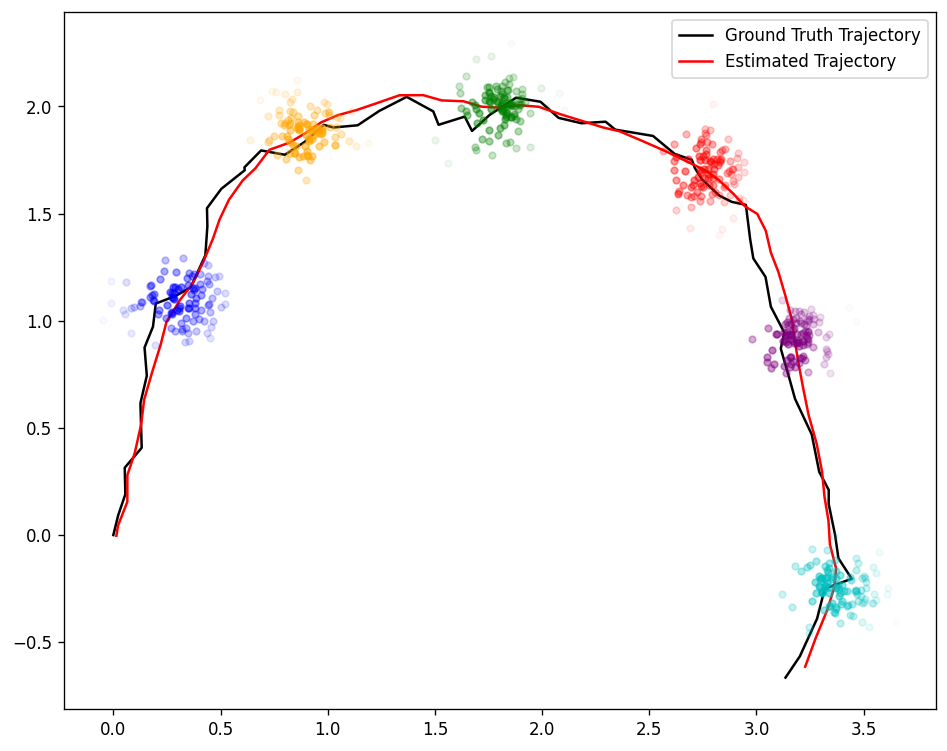

In [87]:
# Visualizer
def visualize_trajectories(ground_truth_trajectory, particles_trajectory, weights_trajectory):
    # visualize the ground truth and particles
    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=120, tight_layout=True)
    ax.set_aspect('equal')

    # plot the ground truth trajectory in black
    ax.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], linestyle='-', markersize=2, color='k', label='Ground Truth Trajectory')

    # calculate the weighted mean of the particles trajectory
    mean_trajectory = np.zeros((particles_trajectory.shape[0], 2))
    for i in range(0, particles_trajectory.shape[0]):
        for j in range(particles_trajectory.shape[1]):
            mean_x = np.sum(particles_trajectory[i,:,0] * weights_trajectory[i,:])
            mean_y = np.sum(particles_trajectory[i,:,1] * weights_trajectory[i,:])
            mean_trajectory[i,:] = np.array([mean_x, mean_y])

    # plot the mean trajectory in red
    ax.plot(mean_trajectory[:,0], mean_trajectory[:,1], linestyle='-', markersize=2, color='r', label='Estimated Trajectory')

    # plot the particles at an interval of 1 second
    # the weights are used to adjust the opacity of the particles
    color_val = ['blue', 'orange', 'green', 'red', 'purple', 'c', 'k']
    count = 0
    for i in range(0, particles_trajectory.shape[0], 10):
        if i == 0:
            continue
        # normalize the weights for visualization
        weights_trajectory[i] /= np.max(weights_trajectory[i])
        for j in range(particles_trajectory.shape[1]):
            ax.plot(particles_trajectory[i,j,0], particles_trajectory[i,j,1], linestyle='', marker='o', markersize=4, color=color_val[count], alpha=weights_trajectory[i,j]/2.0)

        count += 1

    plt.gcf().set_size_inches(8, 8)
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

visualize_trajectories(ground_truth_trajectory.copy(), particles_trajectory.copy(), weights_trajectory.copy())

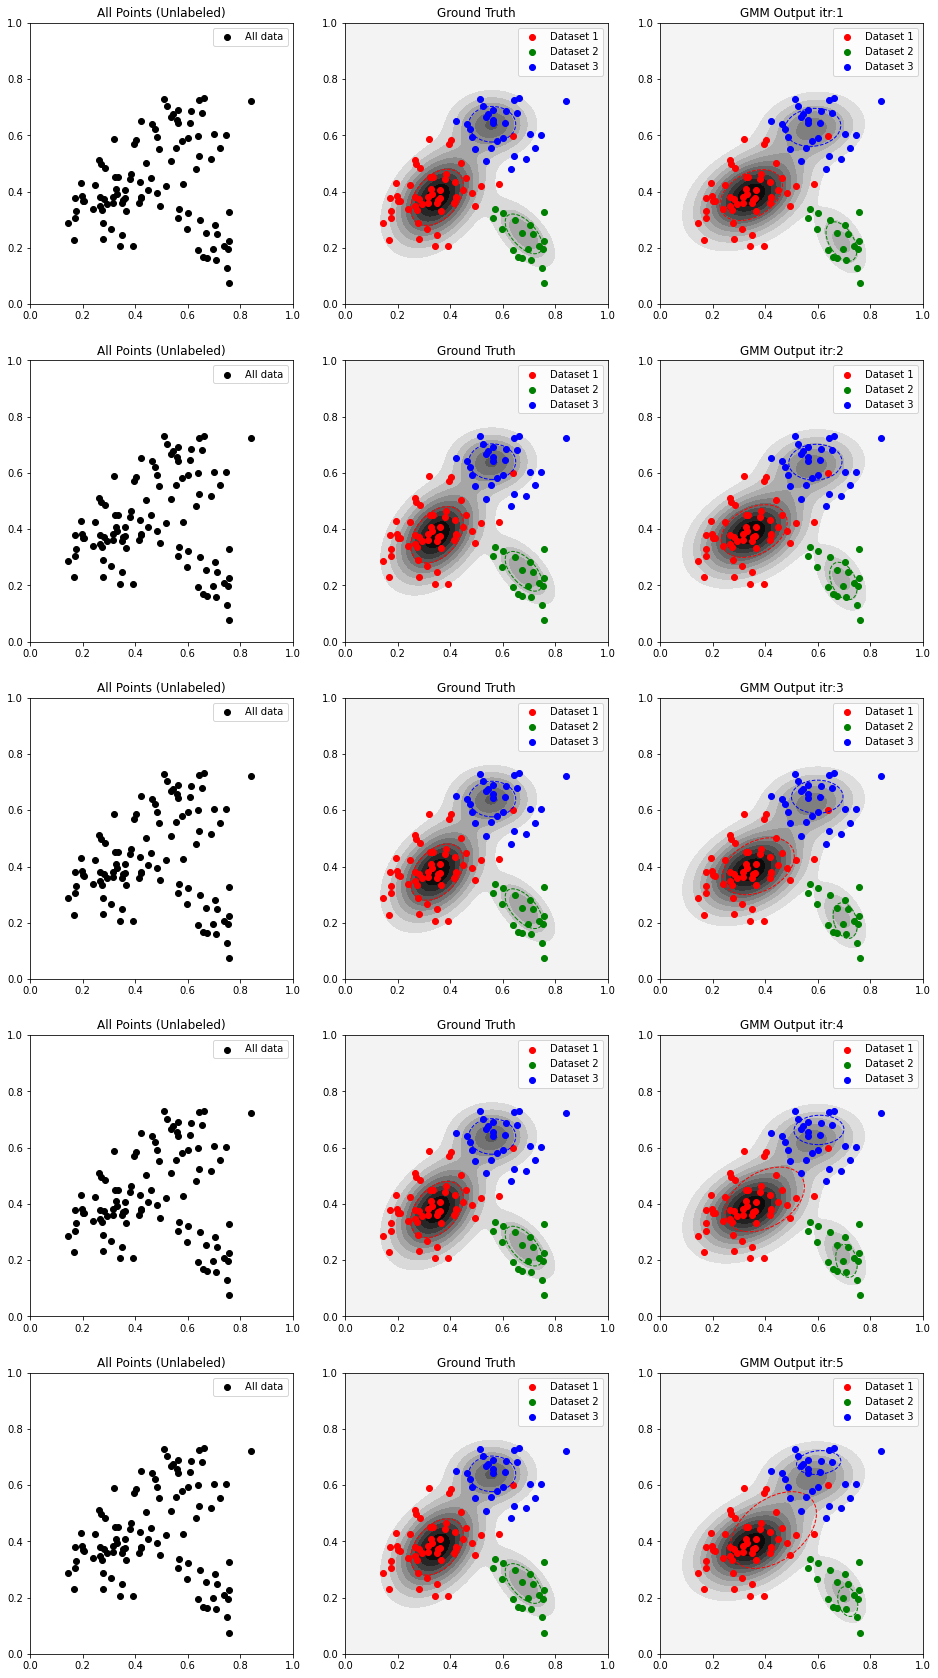

In [198]:
# Problem 3
from scipy.stats import multivariate_normal
w1, w2, w3 = 0.5, 0.2, 0.3
mu1, mu2, mu3 = np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])
cov1 = np.array([[0.01, 0.004],[0.004, 0.01]])
cov2 = np.array([[0.005, -0.003],[-0.003, 0.005]])
cov3 = np.array([[0.008, 0.0],[0.0, 0.004]])

# def prob_x(new_x):
#     p_x = (w1 * ) + (w2 * ) + (w3 * )

def EM_GMM(samples, mixture_vals, iter=5):
    """Runs the procedure for the EM Gaussian Mixture Model algorithm"""
    wk, muk, covk = np.array([]), [], []
    new_mix_vals = []
    for k in range(len(mixture_vals)):
        wk = np.append(wk, mixture_vals[k][0])
        muk.append(mixture_vals[k][1])  # Append the numpy array to the list muk
        covk.append(mixture_vals[k][2])
    
    gamma = np.zeros(shape=[len(samples), len(mixture_vals)])
    for i in range(len(samples)):
        for ki in range(len(mixture_vals)):
            gamma[i][ki] = (wk[ki] * get_normal_conditional(samples[i], wk[ki], muk[ki], covk[ki])) / get_gamma_denom(samples[i], wk, muk, covk)

    for kk in range(len(mixture_vals)):
        axis_sum = np.sum(gamma, axis=0)[kk]
        
        new_mu = np.array([np.dot(samples[:,0], gamma[:,kk]) / axis_sum, np.dot(samples[:,1], gamma[:,kk]) / axis_sum])
        new_cov = np.zeros_like(covk[0])
        new_w = axis_sum / gamma.shape[0]
        for ii in range(len(samples)):
            parenth = samples[ii] - new_mu
            new_cov += gamma[ii][kk] * (np.outer(parenth, parenth))
        new_cov /= axis_sum
        new_mix_vals.append((new_w, new_mu, new_cov))
    return new_mix_vals


def get_gamma_denom(xi, weights, means, cov_mats):
    """Calculates the prob sum"""
    mysum = 0.0
    for r in range(len(weights)):
        mysum += weights[r] * get_normal_conditional(xi, weights[r], means[r], cov_mats[r])
    return mysum

def get_normal_conditional(xi, weight_k, mu_k, cov_k):
    """Gets the normal distribution N(xi|mu_k, cov_k)"""
    N = weight_k * np.exp(-0.5 * np.dot(np.dot(xi - mu_k, np.linalg.inv(cov_k)), xi - mu_k))
    return N

def get_sample_point(mu, cov):
    """Gives a point from a normal distribution from somewhere"""
    return np.random.multivariate_normal(mu, cov, size=2)

def compute_z(X, Y, weights, means, covariance_matrices):
    """Compute function values Z"""
    Z = np.zeros_like(X)  # Initialize array for function values
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for q in range(3):
                Z[i, j] += get_normal_conditional(np.array([X[i,j], Y[i,j]]), weights[q], means[q], covariance_matrices[q])
    return Z


def generate_points(N=100):
#     s1, s2, s3 = [], [], []
#     for i in range(N):
#         set_choice = np.random.uniform(low=0.0, high=1.0)
#         if set_choice < (w1):
#             s1.append(get_sample_point(mu1, cov1)) # x, y
#         elif (w1) <= set_choice < (w1+w2):
#             s2.append(get_sample_point(mu2, cov2)) # x, y
#         else:
#             s3.append(get_sample_point(mu3, cov3)) # x, y
#     return np.array(s1), np.array(s2), np.array(s3)
    s1, s2, s3 = [], [], []
    for i in range(N):
        sample = np.random.choice(np.arange(3), p=[w1, w2, w3])
        rv1 = multivariate_normal(mu1, cov1)
        rv2 = multivariate_normal(mu2, cov2)
        rv3 = multivariate_normal(mu3, cov3)
        match sample:
            case 0:
                s1.append(rv1.rvs()) # x, y
            case 1:
                s2.append(rv2.rvs()) # x, y
            case 2:
                s3.append(rv3.rvs()) # x, y
    return np.array(s1), np.array(s2), np.array(s3)


def get_data(mu, covar):
    return multivariate_normal(mu, covar)

# Plotting function for data points and clustering rings
def plot_data_with_clustering(data, ax, covars=[], means=[]):
    colors = ['r', 'g', 'b']
    for i, dataset in enumerate(data):
        ax.scatter(dataset[:, 0], dataset[:, 1], color=colors[i], label=f'Dataset {i+1}')
        
        # Reshape dataset to 2D
        dataset_2d = dataset.reshape(-1, dataset.shape[-1])

        if len(covars) < 1:
            # Calculate covariance matrix
            cov = np.cov(dataset_2d.T)
        else:
            cov = covars[i]

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

        # Calculate the angle of rotation
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        if len(means) < 1:
            this_mu = np.mean(dataset_2d, axis=0)
        else:
            this_mu = means[i]

        # Create ellipse
        ellipse = Ellipse(xy=this_mu, 
                          width=np.sqrt(eigenvalues[0]) * 2,
                          height=np.sqrt(eigenvalues[1]) * 2,
                          angle=angle,
                          fill=False, color=colors[i], linestyle='--')
        ax.add_patch(ellipse)

# Generate grid points
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z_mat = compute_z(X, Y, weights=[w1, w2, w3], means=[mu1, mu2, mu3], covariance_matrices=[cov1, cov2, cov3])

# Create subplots
fig, axs = plt.subplots(5, 3, figsize=(16, 30))

data1, data2, data3 = generate_points()
all_data = np.concatenate([data1, data2, data3])
for r in range(5):
    # Plotting all points
    axs[r][0].set_title('All Points (Unlabeled)')
    axs[r][0].scatter(all_data[:, 0], all_data[:, 1], color='k', label='All data')
    axs[r][0].set_xlim(0.0, 1.0)
    axs[r][0].set_ylim(0.0, 1.0)
    axs[r][0].legend()

    # Plotting points with clustering rings
    axs[r][1].set_title('Ground Truth')
    axs[r][1].contourf(X, Y, Z_mat, 10, cmap='gray_r')
    plot_data_with_clustering([data1, data2, data3], axs[r][1], covars=[cov1, cov2, cov3], means=[mu1, mu2, mu3])
    axs[r][1].set_xlim(0.0, 1.0)
    axs[r][1].set_ylim(0.0, 1.0)
    axs[r][1].legend()

old_mix = [(0.43, np.array([0.4, 0.38]), cov1),(0.24, np.array([0.68, 0.24]), cov2),(0.33, np.array([0.55, 0.6]), cov3)]
mix_vals = EM_GMM(all_data, old_mix)
weights1 = [mix_vals[0][0], mix_vals[1][0], mix_vals[2][0]]
covs1 = [mix_vals[0][2], mix_vals[1][2], mix_vals[2][2]]
means1 = [mix_vals[0][1], mix_vals[1][1], mix_vals[2][1]]

# Plotting points with clustering rings
axs[0][2].set_title('GMM Output itr:1')
Z_mat2 = compute_z(X, Y, weights=weights1, means=means1, covariance_matrices=covs1)
axs[0][2].contourf(X, Y, Z_mat2, 10, cmap='gray_r')
plot_data_with_clustering([data1, data2, data3], axs[0][2], covars=covs1, means=means1)
axs[0][2].set_xlim(0.0, 1.0)
axs[0][2].set_ylim(0.0, 1.0)
axs[0][2].legend()


mix_vals2 = EM_GMM(all_data, mix_vals)
weights2 = [mix_vals2[0][0], mix_vals2[1][0], mix_vals2[2][0]]
covs2 = [mix_vals2[0][2], mix_vals2[1][2], mix_vals2[2][2]]
means2 = [mix_vals2[0][1], mix_vals2[1][1], mix_vals2[2][1]]
# Plotting points with clustering rings
axs[1][2].set_title('GMM Output itr:2')
Z_mat3 = compute_z(X, Y, weights=weights2, means=means2, covariance_matrices=covs2)
axs[1][2].contourf(X, Y, Z_mat2, 10, cmap='gray_r')
plot_data_with_clustering([data1, data2, data3], axs[1][2], covars=covs2, means=means2)
axs[1][2].set_xlim(0.0, 1.0)
axs[1][2].set_ylim(0.0, 1.0)
axs[1][2].legend()

mix_vals3 = EM_GMM(all_data, mix_vals2)
weights3 = [mix_vals3[0][0], mix_vals3[1][0], mix_vals3[2][0]]
covs3 = [mix_vals3[0][2], mix_vals3[1][2], mix_vals3[2][2]]
means3 = [mix_vals3[0][1], mix_vals3[1][1], mix_vals3[2][1]]
# Plotting points with clustering rings
axs[2][2].set_title('GMM Output itr:3')
Z_mat4 = compute_z(X, Y, weights=weights3, means=means3, covariance_matrices=covs3)
axs[2][2].contourf(X, Y, Z_mat2, 10, cmap='gray_r')
plot_data_with_clustering([data1, data2, data3], axs[2][2], covars=covs3, means=means3)
axs[2][2].set_xlim(0.0, 1.0)
axs[2][2].set_ylim(0.0, 1.0)
axs[2][2].legend()

mix_vals4 = EM_GMM(all_data, mix_vals3)
weights4 = [mix_vals4[0][0], mix_vals4[1][0], mix_vals4[2][0]]
covs4 = [mix_vals4[0][2], mix_vals4[1][2], mix_vals4[2][2]]
means4 = [mix_vals4[0][1], mix_vals4[1][1], mix_vals4[2][1]]
# Plotting points with clustering rings
axs[3][2].set_title('GMM Output itr:4')
Z_mat5 = compute_z(X, Y, weights=weights4, means=means4, covariance_matrices=covs4)
axs[3][2].contourf(X, Y, Z_mat2, 10, cmap='gray_r')
plot_data_with_clustering([data1, data2, data3], axs[3][2], covars=covs4, means=means4)
axs[3][2].set_xlim(0.0, 1.0)
axs[3][2].set_ylim(0.0, 1.0)
axs[3][2].legend()

mix_vals5 = EM_GMM(all_data, mix_vals4)
weights5 = [mix_vals5[0][0], mix_vals5[1][0], mix_vals5[2][0]]
covs5 = [mix_vals5[0][2], mix_vals5[1][2], mix_vals5[2][2]]
means5 = [mix_vals5[0][1], mix_vals5[1][1], mix_vals5[2][1]]
# Plotting points with clustering rings
axs[4][2].set_title('GMM Output itr:5')
Z_mat6 = compute_z(X, Y, weights=weights5, means=means5, covariance_matrices=covs5)
axs[4][2].contourf(X, Y, Z_mat2, 10, cmap='gray_r')
plot_data_with_clustering([data1, data2, data3], axs[4][2], covars=covs5, means=means5)
axs[4][2].set_xlim(0.0, 1.0)
axs[4][2].set_ylim(0.0, 1.0)
axs[4][2].legend()

plt.show()